In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html
!pip uninstall torch_nightly
#!pip uninstall fastai==1.0.38
!pip install fastai==1.0.27
!pip install torchtext==0.2.3

import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

Skipping torch-nightly as it is not installed.
1.0.0
True
True


In [3]:
import fastai
print(fastai.__version__)
from fastai import *
from fastai.vision import *

1.0.27


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

import json

from utils import *

In [0]:
NUM_SAMPLES_PER_CLASS = 1_000
#NUM_VAL = 50 * 340
NUM_VAL = 1000

In [0]:
PATH = Path('sample_data/txt')

In [0]:
PATH.mkdir(exist_ok=True)
(PATH/'train').mkdir(exist_ok=True)
(PATH/'test').mkdir(exist_ok=True)

In [0]:
def create_train_txts_from_df(path):
    df = pd.read_csv(path)
    klass = '_'.join(path.stem.split())
    (PATH/'train'/klass).mkdir(exist_ok=True)
    for row in df.sample(NUM_SAMPLES_PER_CLASS).iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id,
            'recognized': row[1].recognized
        }
        with open(PATH/'train'/klass/f'{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

def create_test_txts_from_df(path):
    df = pd.read_csv(path)
    for row in df.iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id
        }
        with open(PATH/'test'/f'{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

In [87]:
%cd /
%cd content
%pwd
shutil.move("test_simplified.csv", "sample_data")

/
/content


'sample_data/test_simplified.csv'

In [133]:
%time create_test_txts_from_df('sample_data/test_simplified.csv')

CPU times: user 55.4 s, sys: 7.12 s, total: 1min 2s
Wall time: 1min 3s


In [134]:
!ls sample_data/txt/test/9000003627287620.txt
!ls sample_data/txt/test/9000297423888040.txt
!ls sample_data/txt/test/9999996442242300.txt

sample_data/txt/test/9000003627287620.txt
sample_data/txt/test/9000297423888040.txt
sample_data/txt/test/9999996442242300.txt


In [0]:
%time for p in Path('sample_data/txt/train').iterdir(): create_train_txts_from_df(p)

In [0]:
sz = 128
bs = 640

In [0]:
def create_func(path):
    with open(path) as f: j = json.load(f)
    drawing = list2drawing(j['drawing'], size=sz)
    tensor = drawing2tensor(drawing)
    return Image(tensor.div_(255))

In [138]:
item_list = ItemList.from_folder(PATH/'train', create_func=create_func)
print(item_list)

ItemList (14000 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: sample_data/txt/train


In [139]:
idxs = np.arange(item_list.items.shape[0])
print(idxs)
np.random.shuffle(idxs)
val_idxs = idxs[:NUM_VAL]
print(val_idxs)

[    0     1     2     3 ... 13996 13997 13998 13999]
[ 4056  7434  3522  6491 ... 10134  8309  9714  6442]


In [140]:
item_lists = item_list.split_by_idx(val_idxs)
print(item_lists)

ItemLists;
Train: ItemList (13000 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: sample_data/txt/train;
Valid: ItemList (1000 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: sample_data/txt/train;
Test: None


In [0]:
label_lists = item_lists.label_from_folder()
pd.to_pickle(label_lists.train.y.classes, 'sample_data/classes.pkl')

In [0]:
classes = pd.read_pickle('sample_data/classes.pkl')

label_lists = item_lists.label_from_folder(classes=classes)

test_items = ItemList.from_folder(PATH/'test', create_func=create_func)
label_lists.add_test(test_items);


In [0]:

train_dl = DataLoader(label_lists.train, bs, True, num_workers=12)
valid_dl = DataLoader(label_lists.valid, 2*bs, False, num_workers=12)
test_dl = DataLoader(label_lists.test, 2*bs, False, num_workers=12)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

In [0]:
pd.to_pickle(data_bunch.batch_stats(), f'sample_data/batch_stats_{sz}.pkl')

In [0]:
batch_stats = pd.read_pickle(f'sample_data/batch_stats_{sz}.pkl')

In [0]:
data_bunch.normalize(batch_stats);

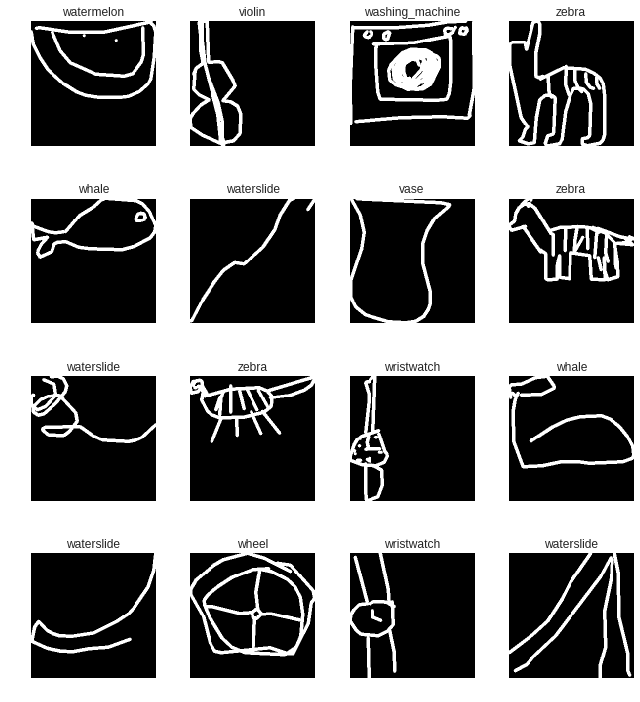

In [148]:
data_bunch.show_batch(rows=4)

In [149]:
%ls sample_data/txt/train

vase/             watermelon/  wheel/        wine_glass/  zebra/
violin/           waterslide/  windmill/     wristwatch/  zigzag/
washing_machine/  whale/       wine_bottle/  yoga/


In [0]:
name = f'res34-{sz}'

In [0]:
learn = create_cnn(data_bunch, models.resnet34, metrics=[accuracy, map3])


In [152]:
learn.fit_one_cycle(2)

In [0]:
learn.save(f'{name}-stage-1')

In [0]:
learn.unfreeze()

In [155]:
learn.fit_one_cycle(6, max_lr=6e-4)


In [0]:
learn.save(f'{name}-stage-2')

# Predict

In [0]:
learn.load(f'{name}-stage-2');

In [0]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
PATH1 = Path('subs')
PATH1.mkdir(exist_ok=True)

In [0]:
create_submission(preds, data_bunch.test_dl, name, classes)


In [160]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,key_id,word
0,9116889588812650,windmill wine_bottle vase
1,9276842682338460,wheel wine_bottle yoga
2,9397716625327190,yoga wristwatch vase
3,9900939444183480,yoga waterslide wristwatch
4,9086841627857940,yoga zebra wine_glass


In [0]:
PATH2 = Path('/root/.kaggle')
PATH2.mkdir(exist_ok=True)
%ls -a /root
%cd /
%cd content
%pwd
shutil.move("kaggle.json", "/root/.kaggle")
!chmod 600 /root/.kaggle/kaggle.json
%ls /root/.kaggle

In [126]:
#!kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "Explorers"




401 - Unauthorized


In [161]:
!ls sample_data/txt/test | wc -l

112199
